***Hierarchial CNN***

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# json_file = "/home/ankitk/Desktop/AVQA/translated_train.json"
# new = pd.read_json(json_file)
import pandas as pd
import json
import tensorflow as tf
import torch
import numpy as np

json_file = "/kaggle/input/merged-data-with-hinglish/merged_data_with_hinglish.json"
data = []
with open(json_file, 'r') as file:
    for line in file:
        data.append(json.loads(line))

train_df = pd.DataFrame(data)


2024-04-19 16:46:25.961462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 16:46:25.961604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 16:46:26.091658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df

,video_id,question_id,type,question_content,templ_values,question_deleted,anser,question,Quest_hindi,ans_hindi,hinglish_question
0,00000136,17,"[""Audio-Visual"", ""Comparative""]",Is the instrument on the <LR> louder than the ...,"[""left"", ""right""]",0,no,Is the instrument on the left louder than the ...,क्या बायीं ओर का वाद्ययंत्र दाहिनी ओर के वाद्य...,नहीं,kya leftick par use on the spant se bacha hai ?
1,00000250,23,"[""Audio-Visual"", ""Existential""]",Is the <Object> in the video always playing?,"[""accordion""]",0,yes,Is the accordion in the video always playing?,क्या वीडियो में अकॉर्डियन हमेशा बजता रहता है?,हाँ,kya video me already playing hai?
2,00000225,27,"[""Audio-Visual"", ""Existential""]",Is there a voiceover?,[],0,yes,Is there a voiceover?,क्या कोई वॉयसओवर है?,हाँ,kya koi voiceover hai?
3,00000152,30,"[""Audio-Visual"", ""Existential""]",Is this sound from the instrument in the video?,[],0,yes,Is this sound from the instrument in the video?,क्या यह ध्वनि वीडियो में मौजूद उपकरण की है?,हाँ,kya ye video mein usey se sound hai ?
4,00000085,32,"[""Audio-Visual"", ""Existential""]",Is there a voiceover?,[],0,no,Is there a voiceover?,क्या कोई वॉयसओवर है?,नहीं,kya koi voiceover hai?
...,...,...,...,...,...,...,...,...,...,...,...
9995,00003985,28445,"[""Visual"", ""Counting""]",Are there <Object> and <Object> instruments in...,"[""banjo"", ""violin""]",0,yes,Are there banjo and violin instruments in the ...,क्या वीडियो में बैंजो और वायलिन वाद्ययंत्र हैं?,हाँ,kya video me koi break jo aur Goollo stants hai?
9996,00000326,28446,"[""Audio"", ""Comparative""]",Is the <Object> playing longer than the <Object>?,"[""piano"", ""violin""]",0,no,Is the piano playing longer than the violin?,क्या पियानो वायलिन से अधिक देर तक बजता है?,नहीं,kya piano Goline se zyada baja raha hai?
9997,00003730,28458,"[""Audio-Visual"", ""Comparative""]",Is the <Object> on the <LR> more rhythmic than...,"[""cello"", ""left"", ""ukulele"", ""right""]",0,no,Is the cello on the left more rhythmic than th...,क्या बायीं ओर का सेलो दायीं ओर के युकुलेले की ...,नहीं,kya cello abhi baaki lambeee se bache hai . . ...
9998,00008427,28462,"[""Visual"", ""Counting""]",Are there <Object> and <Object> instruments in...,"[""violin"", ""cello""]",0,yes,Are there violin and cello instruments in the ...,क्या वीडियो में वायलिन और सेलो वाद्ययंत्र हैं?,हाँ,kya video me Golino aur cello stans hai?


In [4]:
import numpy as np
import os

def load_video_embeddings(folder_path, df):
    embeddings = []
    problematic_ids = []
    problematic_indices = []
    
    for index, video_id in enumerate(df['video_id']):
        if video_id.startswith('vv'):
            video_id = video_id[2:]
        
        file_path = os.path.join(folder_path, f"{video_id}.npy")
        
        try:
            embedding = np.load(file_path)
            embeddings.append(embedding)
        except FileNotFoundError:
            problematic_ids.append(video_id)
            problematic_indices.append(index)
    
    embeddings_array = np.array(embeddings)
    return embeddings_array, problematic_ids, problematic_indices

# Usage
folder_path = '/kaggle/input/video-features-new/video_features_new'
video_array, problematic_ids_video, problematic_indices_video = load_video_embeddings(folder_path, train_df)
print("Shape of loaded video embeddings:", video_array.shape)
print("Problematic video IDs:", problematic_ids_video)
print("Indices of problematic video IDs:", problematic_indices_video)

Shape of loaded video embeddings: (9992, 768)
Problematic video IDs: ['00000572', '00006564', '00006505', '00002841', '00005665', '00003730', '00008427', '00002309']
Indices of problematic video IDs: [9982, 9983, 9985, 9990, 9993, 9997, 9998, 9999]


In [5]:
def load_audio_embeddings(folder_path, df):
    embeddings = []
    problematic_ids = []
    problematic_indices = []
    
    for index, video_id in enumerate(df['video_id']):
        if video_id.startswith('vv'):
            video_id = video_id[2:]
        
        file_path = os.path.join(folder_path, f"{video_id}.npy")
        
        try:
            embedding = np.load(file_path)
            embeddings.append(embedding)
        except FileNotFoundError:
            problematic_ids.append(video_id)
            problematic_indices.append(index)
    
    embeddings_array = np.array(embeddings)
    return embeddings_array, problematic_ids, problematic_indices

# Usage
folder_path = '/kaggle/input/audio-features-new/Audio_features'
audio_array, problematic_ids_audio, problematic_indices_audio = load_audio_embeddings(folder_path, train_df)
print("Shape of loaded audio embeddings:", audio_array.shape)
print("Problematic audio IDs:", problematic_ids_audio)
print("Indices of problematic audio IDs:", problematic_indices_audio)


Shape of loaded audio embeddings: (9997, 768)
Problematic audio IDs: ['00000572', '00002841', '00002309']
Indices of problematic audio IDs: [9982, 9990, 9999]


In [6]:
# Convert lists to sets and find the union
total_prob = list(set(problematic_ids_video).union(set(problematic_ids_audio)))

print(total_prob)

['00003730', '00008427', '00002309', '00006505', '00002841', '00000572', '00006564', '00005665']


In [7]:
# Convert lists to sets and find the union
prob_indices = list(set(problematic_indices_video).union(set(problematic_indices_audio)))

print(prob_indices)

[9985, 9990, 9993, 9997, 9998, 9999, 9982, 9983]


In [8]:
# Assume these are the video_ids to be dropped
total_prob = ['00006505', '00003730', '00002309', '00008427', '00000572', '00005665', '00002841', '00006564','vv00006505', 'vv00003730', 'vv00002309', 'vv00008427', 'vv00000572', 'vv00005665', 'vv00002841', 'vv00006564']

# Function to drop rows
def drop_rows_by_video_id(df, total_prob):
    # Create a mask to identify rows with video_id present in total_prob
    mask = df['video_id'].isin(total_prob)
    print(f"Number of rows to drop: {mask.sum()}")  # Diagnostic print

    # Invert the mask to keep rows where video_id is not in total_prob
    filtered_df = df[~mask]
    return filtered_df

# Example usage
filtered_df = drop_rows_by_video_id(train_df, total_prob)
print("Original DataFrame shape:", train_df.shape)
print("Filtered DataFrame shape:", filtered_df.shape)

# Diagnostic check to ensure all IDs are accounted for
print("Missing IDs not in DataFrame:", set(total_prob) - set(train_df['video_id']))

Number of rows to drop: 8
Original DataFrame shape: (10000, 11)
Filtered DataFrame shape: (9992, 11)
Missing IDs not in DataFrame: {'vv00003730', 'vv00005665', 'vv00006505', 'vv00008427', 'vv00006564', '00002309', '00002841', '00000572'}


In [9]:
train_df=filtered_df
train_df.shape

(9992, 11)

In [10]:
hinglish_array = np.load("/kaggle/input/hinglish-question-embeddings/hinglish_question_embeddings.npy")
print(hinglish_array.shape)

english_array = np.load("/kaggle/input/english-question-embeddings/english_question_embeddings.npy")
print(english_array.shape)

(10000, 768)
(10000, 768)


In [11]:
# Create masks to filter out problematic indices
mask = np.ones(hinglish_array.shape[0], dtype=bool)  # Create a mask that is True for all indices
mask[prob_indices] = False  # Set problematic indices to False

# Apply masks to filter arrays
filtered_hinglish_array = hinglish_array[mask]
filtered_english_array = english_array[mask]

# Print new shapes after removing problematic indices
print("Filtered Hinglish array shape:", filtered_hinglish_array.shape)
print("Filtered English array shape:", filtered_english_array.shape)

Filtered Hinglish array shape: (9992, 768)
Filtered English array shape: (9992, 768)


In [12]:
hinglish_array=filtered_hinglish_array
english_array=filtered_english_array

In [13]:
print(hinglish_array.shape)
print(english_array.shape)

(9992, 768)
(9992, 768)


In [14]:
folder_path = '/kaggle/input/video-features-new/video_features_new'
video_array, problematic_ids_video, problematic_indices_video = load_video_embeddings(folder_path, train_df)
video_array.shape

(9992, 768)

In [15]:
folder_path = '/kaggle/input/audio-features-new/Audio_features'
audio_array, problematic_ids_audio, problematic_indices_audio = load_audio_embeddings(folder_path, train_df)
print("Shape of loaded audio embeddings:", audio_array.shape)

Shape of loaded audio embeddings: (9992, 768)


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['anser'])
train_df.head()

/tmp/ipykernel_34/1731024460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = le.fit_transform(train_df['anser'])


,video_id,question_id,type,question_content,templ_values,question_deleted,anser,question,Quest_hindi,ans_hindi,hinglish_question,labels
0,00000136,17,"[""Audio-Visual"", ""Comparative""]",Is the instrument on the <LR> louder than the ...,"[""left"", ""right""]",0,no,Is the instrument on the left louder than the ...,क्या बायीं ओर का वाद्ययंत्र दाहिनी ओर के वाद्य...,नहीं,kya leftick par use on the spant se bacha hai ?,0
1,00000250,23,"[""Audio-Visual"", ""Existential""]",Is the <Object> in the video always playing?,"[""accordion""]",0,yes,Is the accordion in the video always playing?,क्या वीडियो में अकॉर्डियन हमेशा बजता रहता है?,हाँ,kya video me already playing hai?,1
2,00000225,27,"[""Audio-Visual"", ""Existential""]",Is there a voiceover?,[],0,yes,Is there a voiceover?,क्या कोई वॉयसओवर है?,हाँ,kya koi voiceover hai?,1
3,00000152,30,"[""Audio-Visual"", ""Existential""]",Is this sound from the instrument in the video?,[],0,yes,Is this sound from the instrument in the video?,क्या यह ध्वनि वीडियो में मौजूद उपकरण की है?,हाँ,kya ye video mein usey se sound hai ?,1
4,00000085,32,"[""Audio-Visual"", ""Existential""]",Is there a voiceover?,[],0,no,Is there a voiceover?,क्या कोई वॉयसओवर है?,नहीं,kya koi voiceover hai?,0


In [17]:
train_df = train_df[['video_id', 'question_id', 'type', 'labels']]

In [18]:
from sklearn.model_selection import train_test_split
X_trainv, X_testv, y_train, y_test = train_test_split(video_array, train_df['labels'], test_size=0.2, random_state=42)

print("For Video:")
print("X_train shape:", X_trainv.shape)
print("X_test shape:", X_testv.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_traina, X_testa, y_train, y_test = train_test_split(audio_array, train_df['labels'], test_size=0.2, random_state=42)

print("For Audio:")
print("X_train shape:", X_traina.shape)
print("X_test shape:", X_testa.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




X_traint, X_testt, y_train, y_test = train_test_split(hinglish_array, train_df['labels'], test_size=0.2, random_state=42)

print("For Audio:")
print("X_train shape:", X_traint.shape)
print("X_test shape:", X_testt.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

For Video:
X_train shape: (7993, 768)
X_test shape: (1999, 768)
y_train shape: (7993,)
y_test shape: (1999,)
For Audio:
X_train shape: (7993, 768)
X_test shape: (1999, 768)
y_train shape: (7993,)
y_test shape: (1999,)
For Audio:
X_train shape: (7993, 768)
X_test shape: (1999, 768)
y_train shape: (7993,)
y_test shape: (1999,)


In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

def compile_and_train_model(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=16):
    # Define the optimizer
    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    # Define callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                     factor=0.2,
                                                     patience=1,
                                                     verbose=1,
                                                     min_delta=1e-4,
                                                     min_lr=1e-15,
                                                     mode='max')
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                     min_delta=1e-4,
                                                     patience=70,
                                                     mode='max',
                                                     restore_best_weights=True,
                                                     verbose=1)
    
    callbacks = [earlystopping, reduce_lr]

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Plot training history
    plot_history(history)

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



(run till above if meory exhausts)

In [22]:
import tensorflow as tf

def create_model_video_audio_then_text():
    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    concatenated_video_audio = tf.keras.layers.Concatenate(axis=1)([video_cnn, audio_cnn])

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_video_audio, text_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_video, input_audio, input_text], outputs=output)
    return model

model_video_audio_then_text = create_model_video_audio_then_text()


In [23]:
def create_model_video_text_then_audio():
    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_video_text = tf.keras.layers.Concatenate(axis=1)([video_cnn, text_cnn])

    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_video_text, audio_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_video, input_text, input_audio], outputs=output)
    return model

model_video_text_then_audio = create_model_video_text_then_audio()


In [19]:
def create_model_audio_text_then_video():
    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_audio_text = tf.keras.layers.Concatenate(axis=1)([audio_cnn, text_cnn])

    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_audio_text, video_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_audio, input_text, input_video], outputs=output)
    return model

model_audio_text_then_video = create_model_audio_text_then_video()


Epoch 1/20
 27/500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6333 - loss: 0.7594

I0000 00:00:1713543135.111469     184 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6698 - loss: 0.6397 - val_accuracy: 0.7014 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7312 - loss: 0.5337 - val_accuracy: 0.7234 - val_loss: 0.5515 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7492 - loss: 0.5051 - val_accuracy: 0.7274 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 4/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.4768
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7720 - loss: 0.4769 - val_accuracy: 0.7149 - val_loss: 0.5626 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7903 - loss: 0.4359 - val_accuracy: 0.7469 - val_loss: 0.5528 - learning_rate: 2.0000e-04
Epoch 6/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8164 - loss: 0.3974
Epoch 6

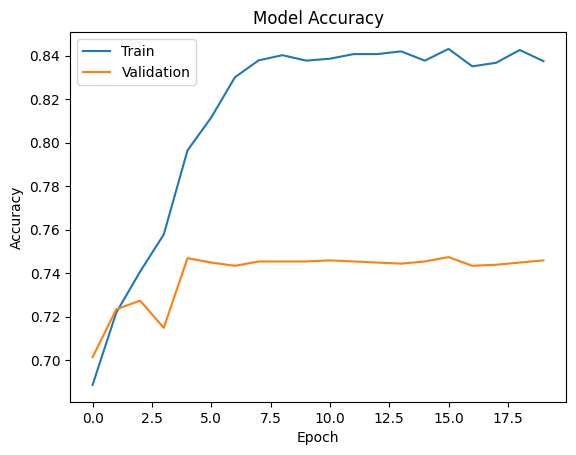

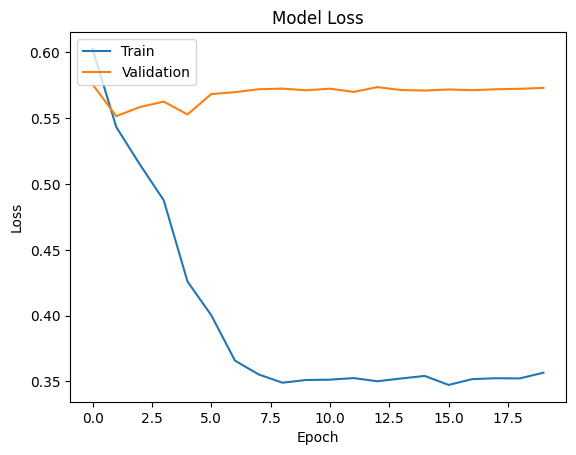

In [26]:
model_video_audio_then_text = create_model_video_audio_then_text()
compile_and_train_model(model_video_audio_then_text, [X_trainv, X_traina, X_traint], y_train, [X_testv, X_testa, X_testt], y_test)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6643 - loss: 0.6482 - val_accuracy: 0.5773 - val_loss: 1.3118 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7171 - loss: 0.5455 - val_accuracy: 0.7229 - val_loss: 0.5715 - learning_rate: 0.0010
Epoch 3/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7356 - loss: 0.5151
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7356 - loss: 0.5152 - val_accuracy: 0.7034 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7712 - loss: 0.4692 - val_accuracy: 0.7424 - val_loss: 0.5262 - learning_rate: 2.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8015 - loss: 0.4244 - val_accuracy: 0.7474 - val_loss: 0.5373 - learning_rate: 2.0000e-04
Epoch 6/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8185 - loss:

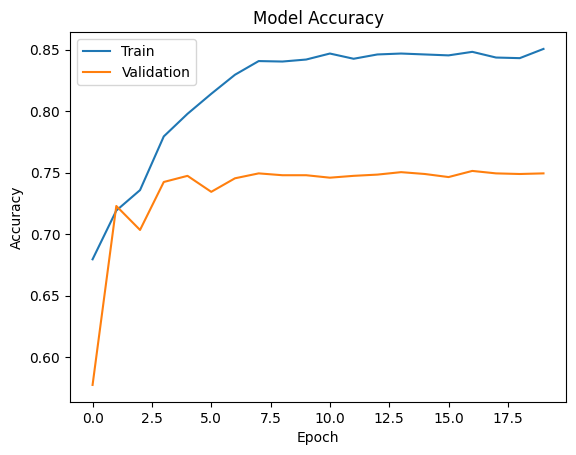

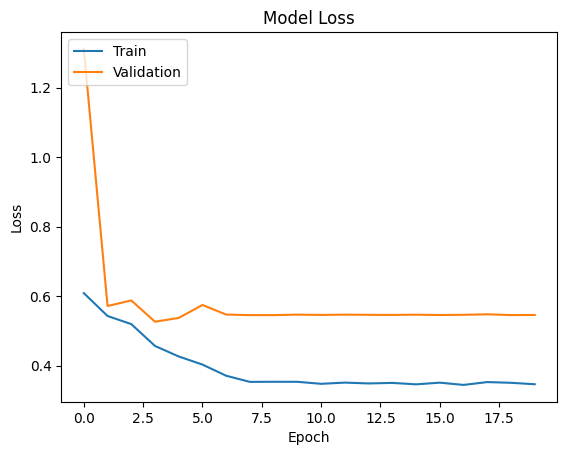

In [27]:
model_video_text_then_audio = create_model_video_text_then_audio()
compile_and_train_model(model_video_text_then_audio, [X_trainv, X_traint, X_traina], y_train, [X_testv, X_testt, X_testa], y_test)


Epoch 1/20
 24/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5592 - loss: 0.7332

I0000 00:00:1713543446.215025     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6773 - loss: 0.6121 - val_accuracy: 0.5868 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7121 - loss: 0.5480 - val_accuracy: 0.6603 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7375 - loss: 0.5115 - val_accuracy: 0.7124 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7595 - loss: 0.4813 - val_accuracy: 0.7354 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7863 - loss: 0.4558
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7863 - loss: 0.4558 - val_accuracy: 0.7164 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 6/20
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8162 - loss: 0.3975
Epoch 6: Re

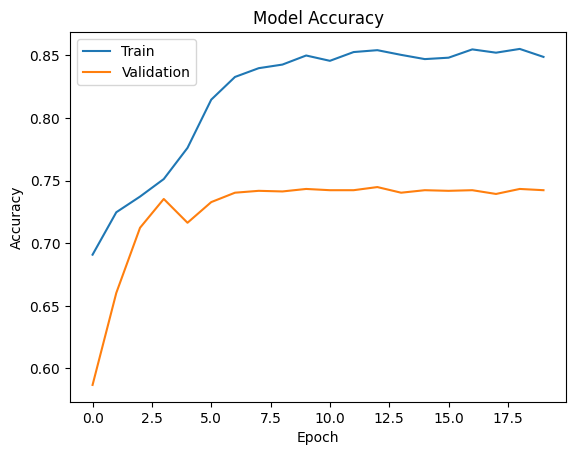

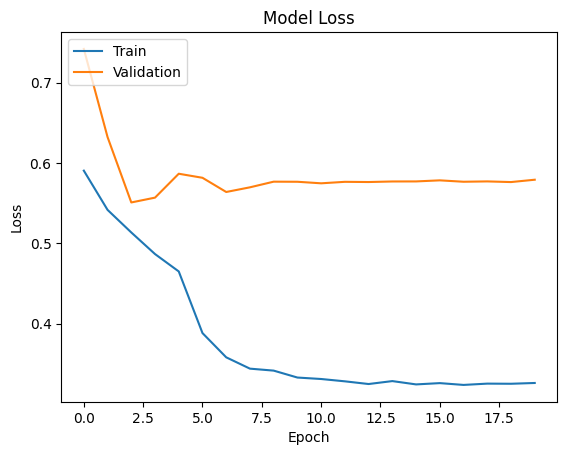

In [21]:
model_audio_text_then_video = create_model_audio_text_then_video()
compile_and_train_model(model_audio_text_then_video, [X_traina, X_traint, X_trainv], y_train, [X_testa, X_testt, X_testv], y_test)


***Hierarchial Transformer***

In [20]:
import keras_nlp
encoder1 = keras_nlp.layers.TransformerEncoder(intermediate_dim=120, num_heads=4)
encoder2 = keras_nlp.layers.TransformerEncoder(intermediate_dim=120, num_heads=4)
encoder3 = keras_nlp.layers.TransformerEncoder(intermediate_dim=120, num_heads=4)

In [23]:
import tensorflow as tf

def create_model_video_audio_then_text_with_transformers(encoder1):
    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = encoder1(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = encoder1(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    concatenated_video_audio = tf.keras.layers.Concatenate(axis=1)([video_cnn, audio_cnn])

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = encoder1(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_video_audio, text_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_video, input_audio, input_text], outputs=output)
    return model


model_video_audio_then_text = create_model_video_audio_then_text_with_transformers(encoder1)


In [21]:
def create_model_video_text_then_audio_with_transformers(encoder1):
    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = encoder1(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = encoder1(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_video_text = tf.keras.layers.Concatenate(axis=1)([video_cnn, text_cnn])

    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = encoder1(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_video_text, audio_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_video, input_text, input_audio], outputs=output)
    return model


model_video_text_then_audio = create_model_video_text_then_audio_with_transformers(encoder1)


In [21]:
def create_model_audio_text_then_video_with_transformers(encoder1):
    input_audio = tf.keras.Input(shape=[768, 1])
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = encoder1(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    input_text = tf.keras.Input(shape=[768, 1])
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = encoder1(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    concatenated_audio_text = tf.keras.layers.Concatenate(axis=1)([audio_cnn, text_cnn])

    input_video = tf.keras.Input(shape=[768, 1])
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = encoder1(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    concatenated_all = tf.keras.layers.Concatenate(axis=1)([concatenated_audio_text, video_cnn])

    x = tf.keras.layers.Dense(200, activation='relu')(concatenated_all)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_audio, input_text, input_video], outputs=output)
    return model


model_audio_text_then_video = create_model_audio_text_then_video_with_transformers(encoder1)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.6636 - loss: 0.6286 - val_accuracy: 0.6968 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 2/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7145 - loss: 0.5510
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7145 - loss: 0.5510 - val_accuracy: 0.5773 - val_loss: 1.9423 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7162 - loss: 0.5429 - val_accuracy: 0.7354 - val_loss: 0.5409 - learning_rate: 2.0000e-04
Epoch 4/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7601 - loss: 0.4918
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7601 - loss: 0.4918 - val_accuracy: 0.7304 - val_loss: 0.5372 - learning_rate: 2.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7753 -

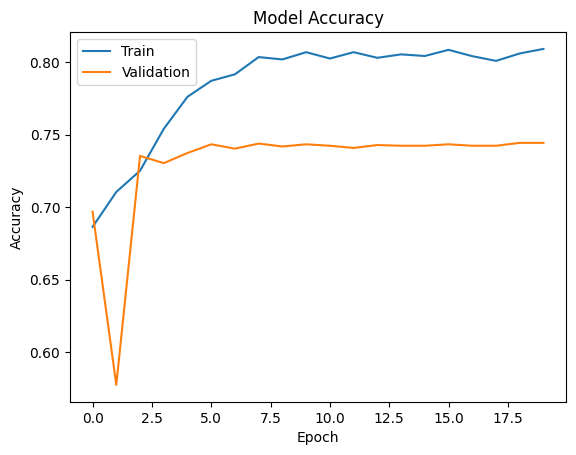

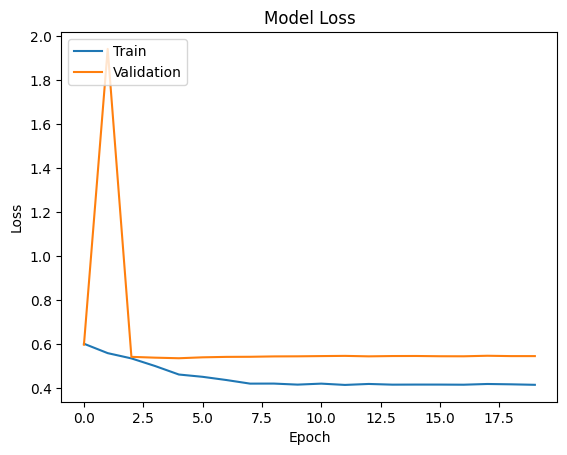

In [26]:
model_video_audio_then_text = create_model_video_audio_then_text_with_transformers(encoder1)
compile_and_train_model(model_video_audio_then_text, [X_trainv, X_traina, X_traint], y_train, [X_testv, X_testa, X_testt], y_test)


Epoch 1/20
 12/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5669 - loss: 0.9058  

I0000 00:00:1713543925.015355     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6655 - loss: 0.6337 - val_accuracy: 0.7094 - val_loss: 0.5611 - learning_rate: 0.0010
Epoch 2/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7239 - loss: 0.5405
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7239 - loss: 0.5405 - val_accuracy: 0.6093 - val_loss: 0.9676 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7605 - loss: 0.4897 - val_accuracy: 0.7294 - val_loss: 0.5549 - learning_rate: 2.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7753 - loss: 0.4563 - val_accuracy: 0.7404 - val_loss: 0.5415 - learning_rate: 2.0000e-04
Epoch 5/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8038 - loss: 0.4043
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8038 - loss: 0.40

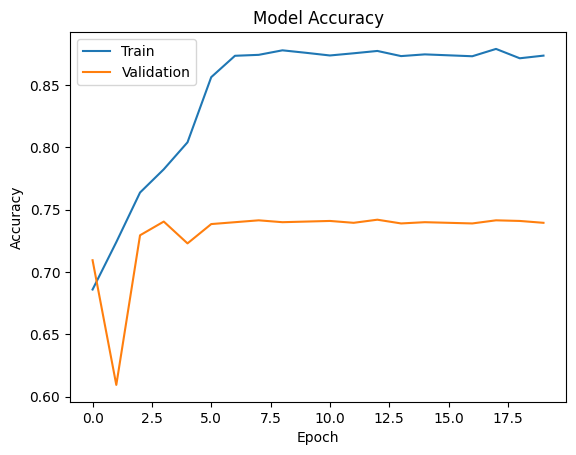

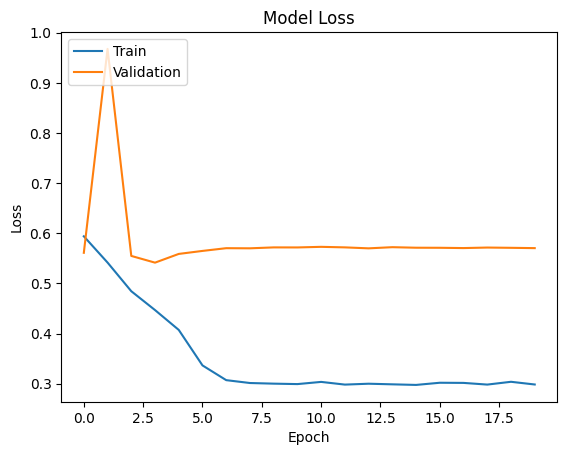

In [23]:
model_video_text_then_audio = create_model_video_text_then_audio_with_transformers(encoder1)
compile_and_train_model(model_video_text_then_audio, [X_trainv, X_traint, X_traina], y_train, [X_testv, X_testt, X_testa], y_test)


Epoch 1/20
 12/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7159 - loss: 0.5971  

I0000 00:00:1713544403.746784     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.6839 - loss: 0.6157 - val_accuracy: 0.6888 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 2/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7135 - loss: 0.5496
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7136 - loss: 0.5495 - val_accuracy: 0.6588 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7684 - loss: 0.4813 - val_accuracy: 0.7329 - val_loss: 0.5391 - learning_rate: 2.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7914 - loss: 0.4358 - val_accuracy: 0.7389 - val_loss: 0.5556 - learning_rate: 2.0000e-04
Epoch 5/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8253 - loss: 0.3828
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8253 - loss: 0.38

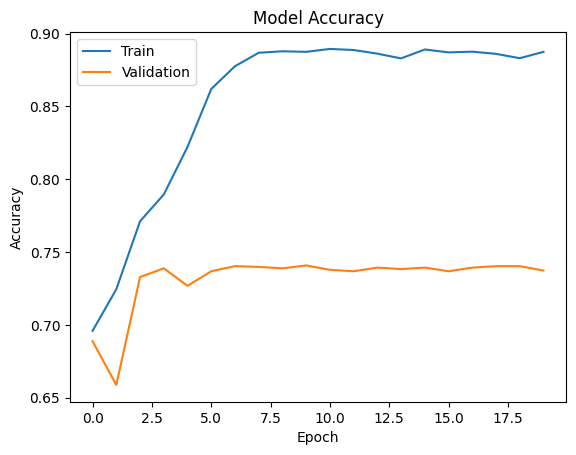

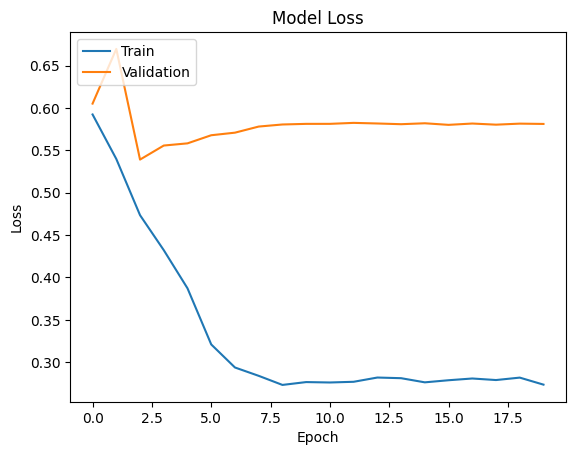

In [22]:
model_audio_text_then_video = create_model_audio_text_then_video_with_transformers(encoder1)
compile_and_train_model(model_audio_text_then_video, [X_traina, X_traint, X_trainv], y_train, [X_testa, X_testt, X_testv], y_test)


***Early Fusion***

In [23]:
import tensorflow as tf

def create_early_fusion_model(encoder1):
    # Define input layers for each modality
    input_video = tf.keras.Input(shape=[768, 1])
    input_audio = tf.keras.Input(shape=[768, 1])
    input_text = tf.keras.Input(shape=[768, 1])

    # Process each modality with a CNN followed by a Transformer encoder
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_processed = encoder1(video_cnn)
    video_processed = tf.keras.layers.Flatten()(video_processed)

    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_processed = encoder1(audio_cnn)
    audio_processed = tf.keras.layers.Flatten()(audio_processed)

    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_processed = encoder1(text_cnn)
    text_processed = tf.keras.layers.Flatten()(text_processed)

    # Early fusion: average the embeddings from each modality
    averaged_embeddings = tf.keras.layers.Average()([video_processed, audio_processed, text_processed])

    # Classifier layers
    x = tf.keras.layers.Dense(200, activation='relu')(averaged_embeddings)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create and return the model
    model = tf.keras.Model(inputs=[input_video, input_audio, input_text], outputs=output)
    return model

# Make sure to define `encoder1` before calling this function.
early_fusion_model = create_early_fusion_model(encoder1)


In [20]:
import tensorflow as tf

def create_early_fusion_cnn_model():
    # Define input layers for each modality
    input_video = tf.keras.Input(shape=[768, 1])
    input_audio = tf.keras.Input(shape=[768, 1])
    input_text = tf.keras.Input(shape=[768, 1])

    # CNN layers for video
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    # CNN layers for audio
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    # CNN layers for text
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    # Early fusion: average the CNN outputs from each modality
    averaged_embeddings = tf.keras.layers.Average()([video_cnn, audio_cnn, text_cnn])

    # Classifier layers
    x = tf.keras.layers.Dense(200, activation='relu',  name= "dense1")(averaged_embeddings)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(90, activation = 'relu', name= "dense2")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(56, activation = 'relu', name= "dense3")(x)
    output = tf.keras.layers.Dense(2, activation='softmax', name= "output")(x)
    model = tf.keras.Model(inputs= [input_video, input_audio, input_text], outputs = output)
    return model

# Instantiate the model
early_fusion_cnn_model = create_early_fusion_cnn_model()

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.6707 - loss: 0.6404 - val_accuracy: 0.7044 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 2/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7229 - loss: 0.5451
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7228 - loss: 0.5452 - val_accuracy: 0.7039 - val_loss: 0.5711 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7655 - loss: 0.4866 - val_accuracy: 0.7424 - val_loss: 0.5339 - learning_rate: 2.0000e-04
Epoch 4/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7869 - loss: 0.4453
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7869 - loss: 0.4453 - val_accuracy: 0.7424 - val_loss: 0.5356 - learning_rate: 2.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8066 -

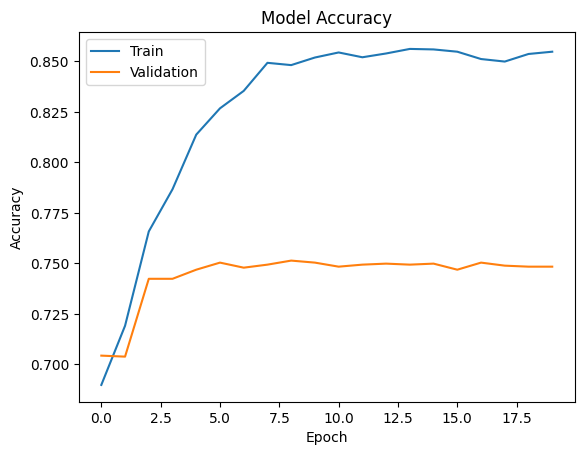

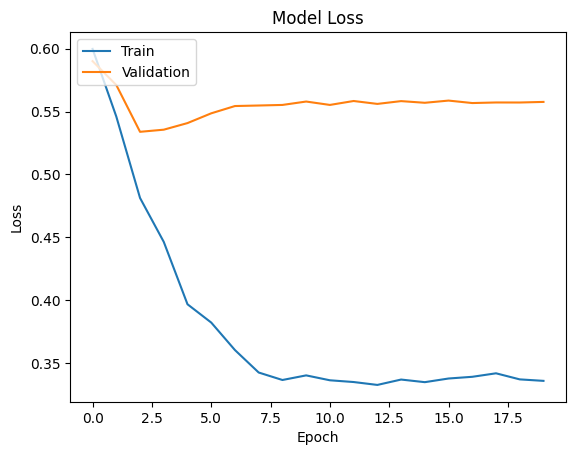

In [24]:
early_fusion_model = create_early_fusion_model(encoder1)
compile_and_train_model(early_fusion_model, [X_trainv, X_traina, X_traint], y_train, [X_testv, X_testa, X_testt], y_test)


Epoch 1/20
 30/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5756 - loss: 0.6911

I0000 00:00:1713544958.851656     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6518 - loss: 0.6303 - val_accuracy: 0.6983 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 2/20
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7151 - loss: 0.5436
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7151 - loss: 0.5436 - val_accuracy: 0.6898 - val_loss: 0.5955 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7485 - loss: 0.5172 - val_accuracy: 0.7324 - val_loss: 0.5460 - learning_rate: 2.0000e-04
Epoch 4/20
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7673 - loss: 0.4684
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7672 - loss: 0.4686 - val_accuracy: 0.7164 - val_loss: 0.6046 - learning_rate: 2.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7879 - loss: 0.4481 - v

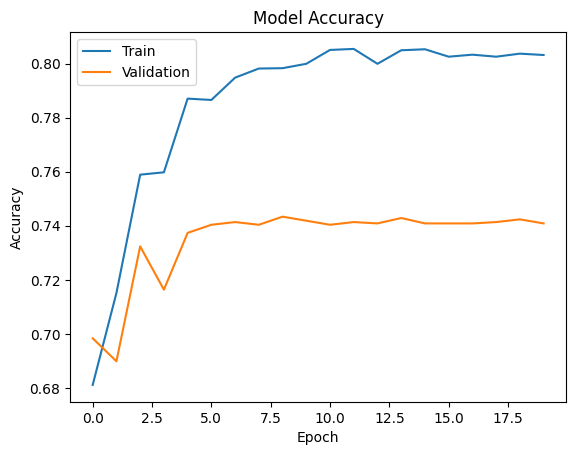

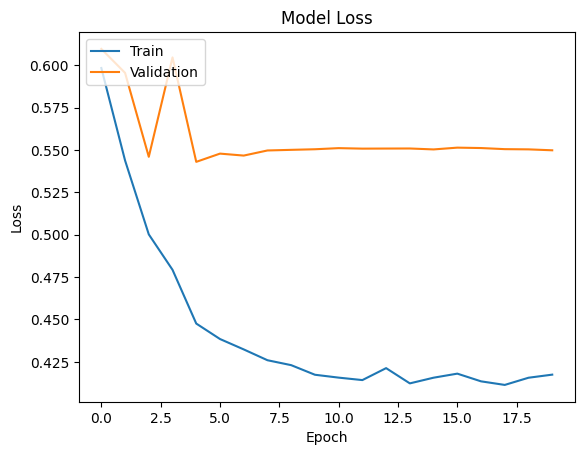

In [21]:
early_fusion_cnn_model = create_early_fusion_cnn_model()
compile_and_train_model(early_fusion_cnn_model, [X_trainv, X_traint, X_traina], y_train, [X_testv, X_testt, X_testa], y_test)


***Baseline (Enlgish Text Embedd)***

In [20]:
X_traint, X_testt, y_train, y_test = train_test_split(english_array, train_df['labels'], test_size=0.2, random_state=42)

print("For Audio:")
print("X_train shape:", X_traint.shape)
print("X_test shape:", X_testt.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

For Audio:
X_train shape: (7993, 768)
X_test shape: (1999, 768)
y_train shape: (7993,)
y_test shape: (1999,)


In [21]:
import tensorflow as tf

def create_simple_cnn_concat_model():
    # Define input layers for each modality
    input_video = tf.keras.Input(shape=(768, 1), name='video_input')
    input_audio = tf.keras.Input(shape=(768, 1), name='audio_input')
    input_text = tf.keras.Input(shape=(768, 1), name='text_input')

    # CNN layers for video
    video_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_video)
    video_cnn = tf.keras.layers.MaxPooling1D()(video_cnn)
    video_cnn = tf.keras.layers.Flatten()(video_cnn)

    # CNN layers for audio
    audio_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_audio)
    audio_cnn = tf.keras.layers.MaxPooling1D()(audio_cnn)
    audio_cnn = tf.keras.layers.Flatten()(audio_cnn)

    # CNN layers for text
    text_cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_text)
    text_cnn = tf.keras.layers.MaxPooling1D()(text_cnn)
    text_cnn = tf.keras.layers.Flatten()(text_cnn)

    # Concatenate all features
    concatenated_features = tf.keras.layers.Concatenate()([video_cnn, audio_cnn, text_cnn])

    # Dense layers for classification
    x = tf.keras.layers.Dense(512, activation='relu')(concatenated_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)  # Adjust the output layer depending on your number of classes

    # Create model
    model = tf.keras.Model(inputs=[input_video, input_audio, input_text], outputs=output)
    return model

# Instantiate the model
simple_cnn_concat_model = create_simple_cnn_concat_model()

Epoch 1/20
 21/500 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5169 - loss: 1.8225

I0000 00:00:1713545254.385538     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6053 - loss: 0.8926 - val_accuracy: 0.6838 - val_loss: 0.5890 - learning_rate: 0.0010
Epoch 2/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6954 - loss: 0.5886
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6953 - loss: 0.5887 - val_accuracy: 0.6783 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 3/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6920 - loss: 0.5694
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6920 - loss: 0.5694 - val_accuracy: 0.6783 - val_loss: 0.5786 - learning_rate: 2.0000e-04
Epoch 4/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6866 - loss: 0.5668
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6867 - loss: 0.5668 - val_ac

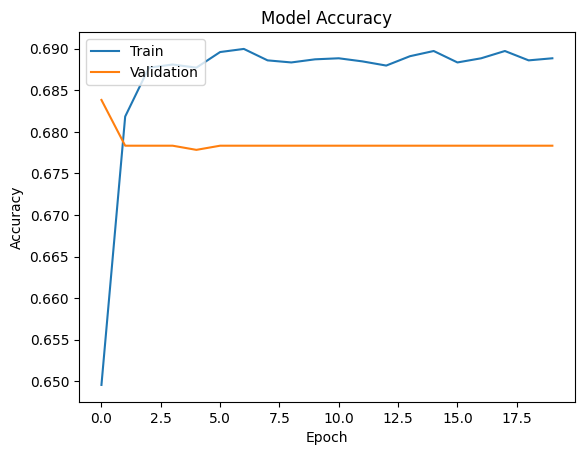

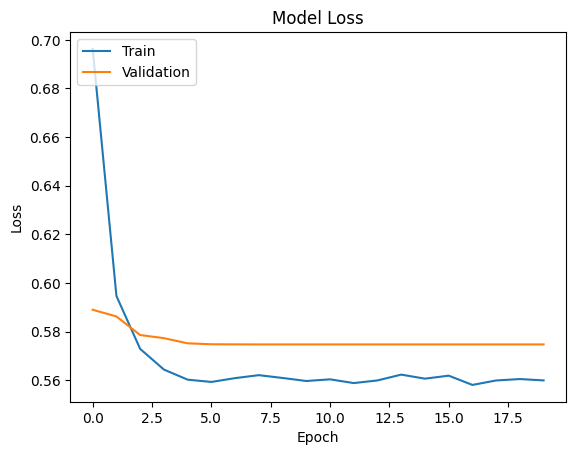

In [22]:
compile_and_train_model(simple_cnn_concat_model, [X_trainv, X_traint, X_traina], y_train, [X_testv, X_testt, X_testa], y_test)
